In [16]:
import torch
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import cv2
import json
from model.models import VLModel, VL2DModel, UNet, UNet3D, UNet2D, LModel
from tools.hp5dataset import MultiFileDataset as Dataset
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from tools.utils import check_clicks_topk
from tqdm import tqdm

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "VLModel": VLModel,
    "VL2DModel": VL2DModel,
    "UNet": UNet,
    "UNet3D": UNet3D,
    "UNet2D": UNet2D,
    "LModel": LModel
}

decoders = {
    "heatmap": "heatmap",
    "point": "point"
}

In [18]:
def load_model(path, model_name):
    model = models[model_name]()
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model

In [105]:
def preprocess_a_for_b(frames):
    # 1. Reverse A frames preprocessing
    frames = frames.float() * 255   # Convert back to float32, range [0, 1]

    # 2. Apply B frames preprocessing (this step might be redundant if it's just float32 conversion)
    frames = torch.tensor(frames)  # Convert to PyTorch tensor

    return frames

def process_image(frames):
    # Convert the image to a tensor
    frames = np.array(frames)
    frames = torch.Tensor(frames).permute(1, 0, 2, 3)
    print(f'frames: {frames.shape}')


    frames = preprocess_a_for_b(frames)
    image_frames = [torch.tensor(frames[i].float()/255) for i in range(frames.shape[0])]

    return image_frames

In [106]:
def visualize_output(output, ax=None, heats=None, save_dir=None):
    output = output.cpu()
    output = output.detach().numpy().squeeze(0).transpose(1, 0)
    if ax is not None:
        ax[0][2].imshow(output, cmap='hot', interpolation='nearest')
        if heats is not None:
            heats = heats.cpu()
            heats = heats.detach().numpy().squeeze(0).transpose(1, 0)
            ax[0][3].imshow(heats, cmap='hot', interpolation='nearest')
        
        ax[0][2].set_aspect('auto')  # Set aspect ratio to 'auto' for natural image dimensions
        ax[0][2].axis("off")
        ax[0][3].set_aspect('auto')  # Set aspect ratio to 'auto' for natural image dimensions
        ax[0][3].axis("off")
    else:
        fig, ax = plt.subplots(1, 1, figsize=(2, 5)) 
        ax.imshow(output, cmap='hot', interpolation='nearest')

    if save_dir is not None:
        plt.savefig(save_dir)
    else:
        plt.savefig('output.png')

In [107]:
def visualize_h5(origin_frames, with_subplot):
    
    origin_frames = origin_frames.cpu()
    # Copy input2 to another variable
    frames = origin_frames.clone()

    concatenated_frames, image_frames = process_image(frames)

    if with_subplot:
        # Adjust figsize to more common proportions and switch dimensions for clarity
        fig, ax = plt.subplots(2, 8, figsize=(32, 16))
        
        # Show first two plots in the first row with proper aspect
        ax[0][0].imshow(concatenated_frames[:3].permute(2, 1, 0))
        ax[0][1].imshow(concatenated_frames[3:].permute(2, 1, 0))
        for i in range(8):
            ax[0][i].set_aspect('auto')  # Set aspect ratio to 'auto' for natural image dimensions
            ax[0][i].axis("off")  # Turn off axis for better visibility

        # Assuming you populate all subplots, otherwise adjust or don't create unnecessary axes
        for i in range(8):
            ax[1][i].imshow(image_frames.permute(1, 3, 2, 0)[i])
            ax[1][i].set_aspect('auto')
            ax[1][i].axis("off")  # Turn off axis if no image is available

        plt.tight_layout()  # Optimize layout to minimize padding and spacing

    return ax

In [108]:
def visualize_h5(origin_frames, with_subplot):
    
    origin_frames = origin_frames.cpu()
    # Copy input2 to another variable
    frames = origin_frames.clone()

    image_frames = process_image(frames)

    if with_subplot:
        # Adjust figsize to more common proportions and switch dimensions for clarity
        fig, ax = plt.subplots(2, 8, figsize=(32, 16))
        
        # Show first two plots in the first row with proper aspect
        ax[0][0].imshow(image_frames[0].permute(2, 1, 0))
        ax[0][1].imshow(image_frames[1].permute(2, 1, 0))
        for i in range(8):
            ax[0][i].set_aspect('auto')  # Set aspect ratio to 'auto' for natural image dimensions
            ax[0][i].axis("off")  # Turn off axis for better visibility

        # Assuming you populate all subplots, otherwise adjust or don't create unnecessary axes
        for i in range(8):
            ax[1][i].imshow(image_frames[i].permute(2, 1, 0))
            ax[1][i].set_aspect('auto')
            ax[1][i].axis("off")  # Turn off axis if no image is available

        plt.tight_layout()  # Optimize layout to minimize padding and spacing

    return ax

Validating:   0%|          | 0/31664 [00:00<?, ?it/s]

frames: torch.Size([8, 3, 256, 512])
image_frames: 0.19607843458652496


/tmp/ipykernel_4030591/1570351648.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frames = torch.tensor(frames)  # Convert to PyTorch tensor
/tmp/ipykernel_4030591/1570351648.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_frames = [torch.tensor(frames[i].float()/255) for i in range(frames.shape[0])]
Validating:   0%|          | 0/31664 [00:01<?, ?it/s]


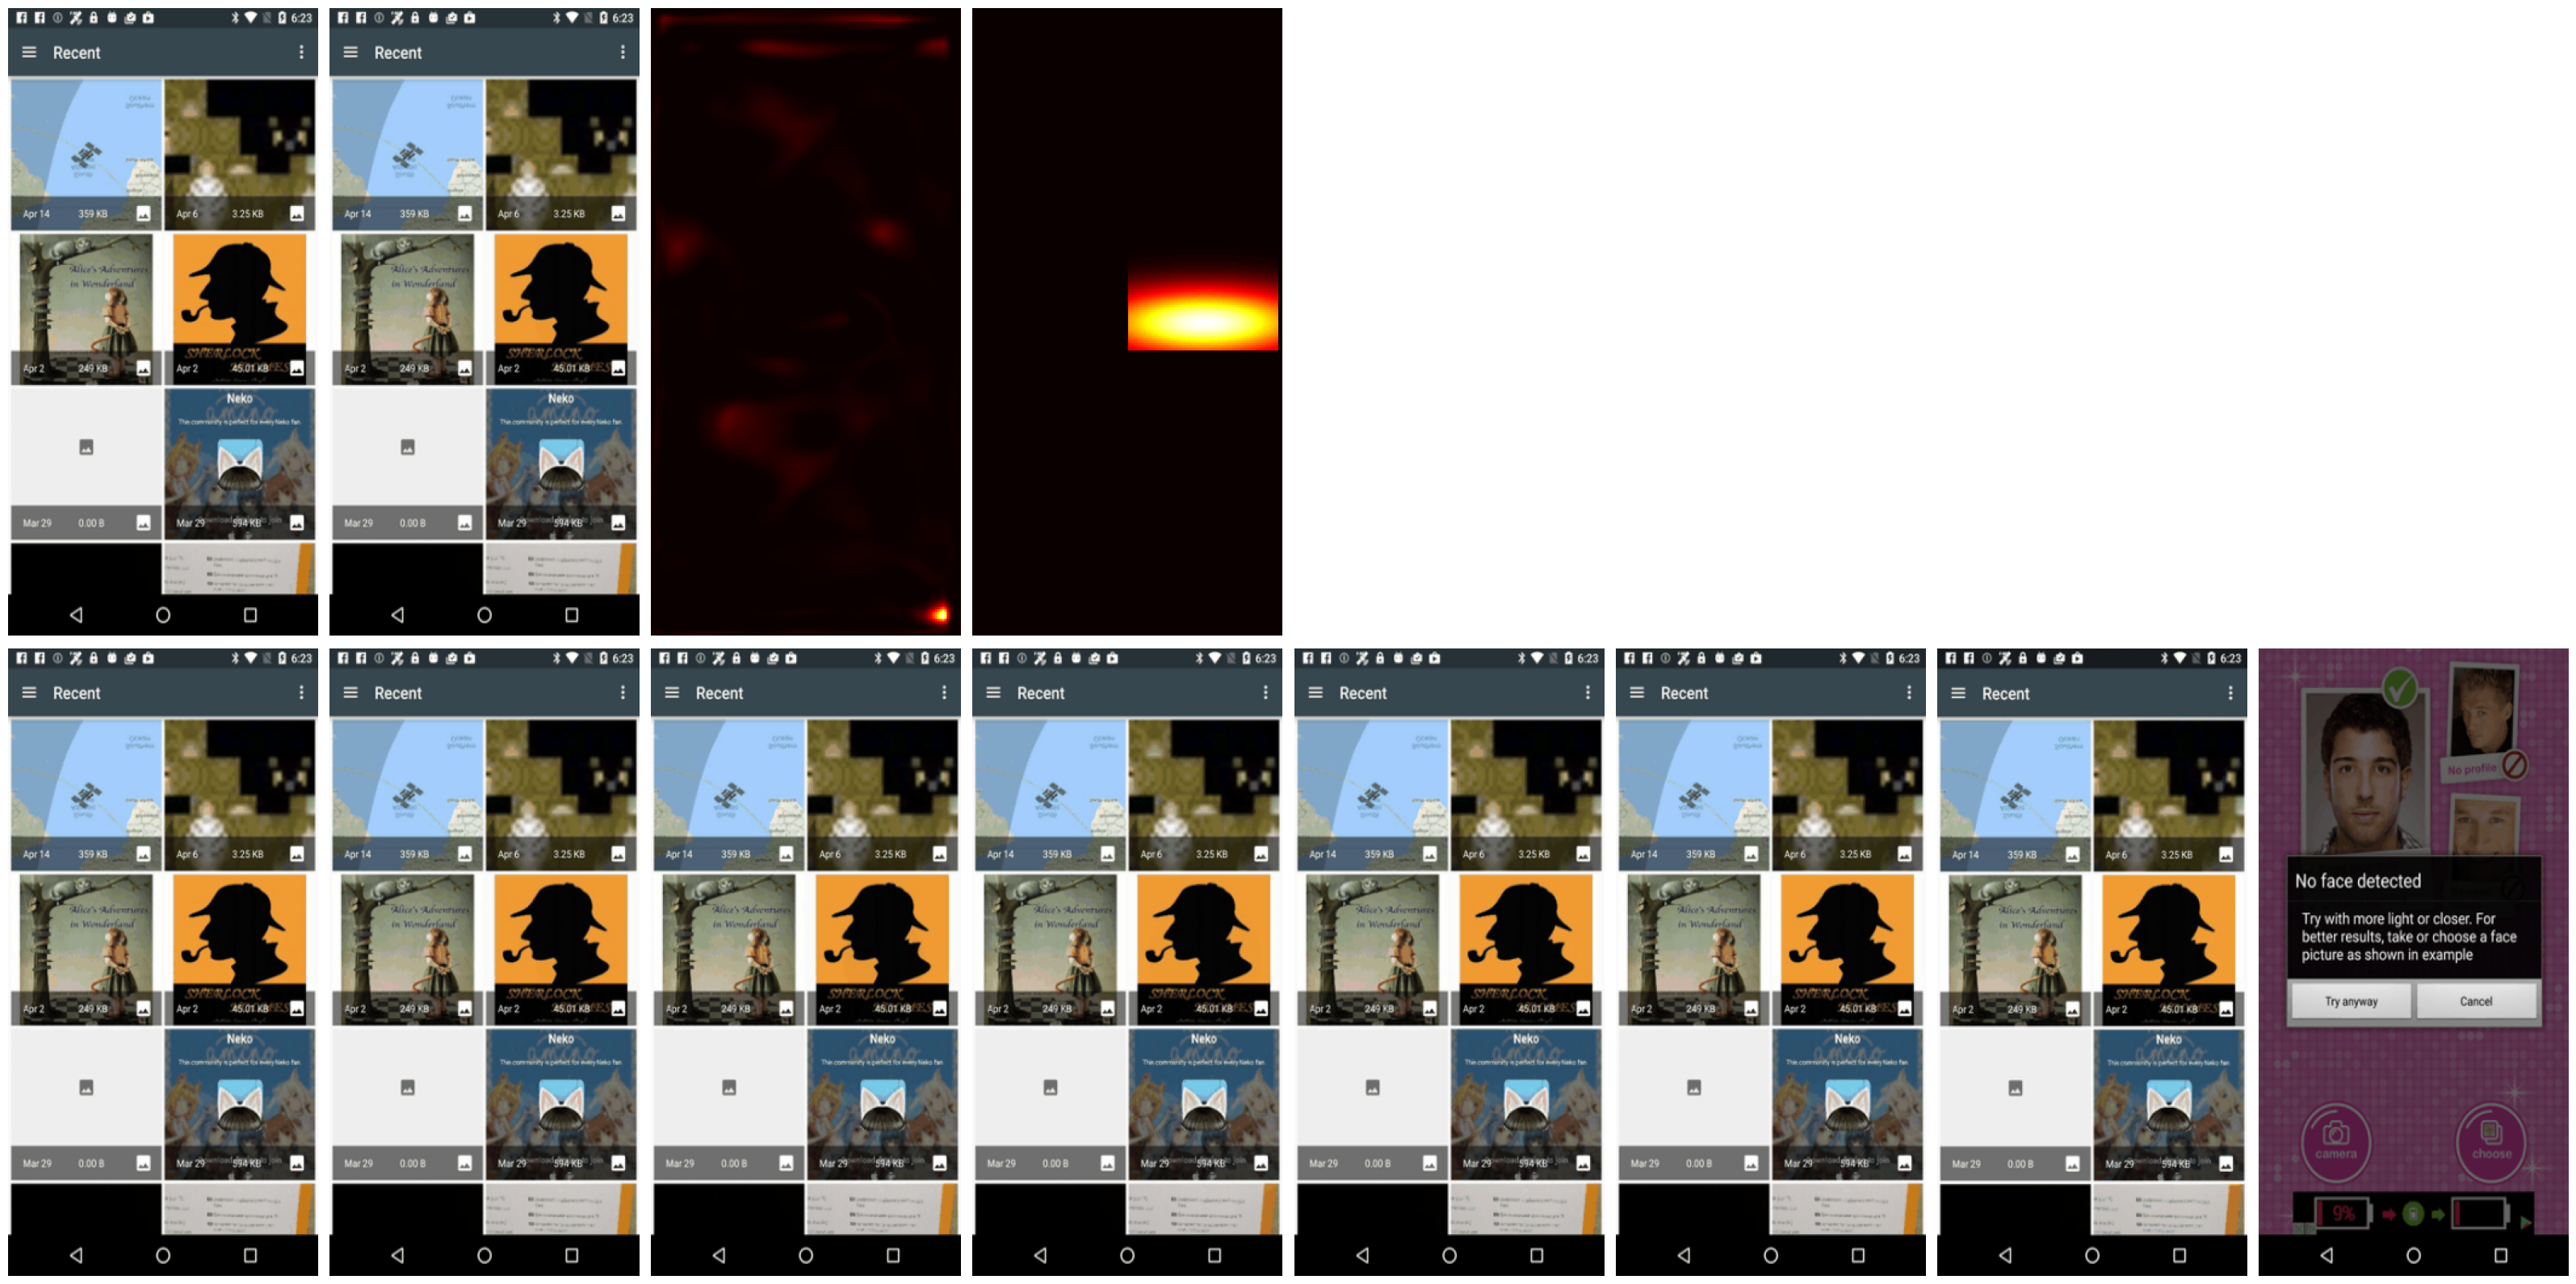

In [109]:
model_path = '/data2/peter/model/auto/VLModel_heatmap_VL2DModel_LAModel_8/VL2DModel_LAModel_8.pth/model_17.pth'
model_name = 'VLModel'
decoder_name = 'heatmap'
h5_file = "/data2/peter/rico"
# h5_file = "/data2/peter/validation_set/unseen"

dataset = Dataset(data_dir=h5_file, type="test", csv_file=None, decode_type=decoder_name)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

model = models[model_name]()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

model.eval()

# remove all images in the folder
import os
import shutil
if os.path.exists('./validation/correct'):
    shutil.rmtree('./validation/correct')
    shutil.rmtree('./validation/wrong')
os.makedirs('./validation/correct')
os.makedirs('./validation/wrong')

with torch.no_grad(), autocast():
    i = 0
    for data in tqdm(data_loader, total=len(data_loader), desc="Validating"):
        text, bound, mask, input2, labels, heats = data
        text, bound, mask, input2, labels, heats = (tensor.to(device) for tensor in [text, bound, mask, input2, labels, heats])

        outputs = model(text, bound, mask, input2)
        precision, check_list = check_clicks_topk(outputs, labels, 1, 10)
        

        for frames, output, heat, check in zip(input2, outputs, heats, check_list):
            ax = visualize_h5_rico(frames, True)
            if check:
                visualize_output(output, ax=ax, heats=heat, save_dir=f"./validation/correct/{i}.png")
            else:
                visualize_output(output, ax=ax, heats=heat, save_dir=f"./validation/wrong/{i}.png")
            i += 1
        
        break
        